### Import Packages

In [22]:
import os
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Read Dataset

In [18]:
train = pd.read_csv('../input/duth-dbirlab2-1/train.csv')
test = pd.read_csv('../input/duth-dbirlab2-1/test.csv')

In [19]:
cols_to_exclude = ['median','quantile_1','quantile_10','quantile_90','quantile_99']

dff = []
ex = False
for c in train.columns:
    for col2e in cols_to_exclude:
        if col2e in c:
            ex = True
    
    if not ex:
        dff.append(c)
    else:
        ex = False

cols_to_exclude = ['obs_id','Overall Probability']

train_filtered = train[dff]
print(train_filtered.shape)
dftc = [c for c in dff if c not in cols_to_exclude]
y_train = train['Overall Probability'].ravel() #ravel coverts a series to a numpy array
x_train = train[dftc].values # converts a dataframe to a numpy array
x_test = test[dftc].values

(527, 4491)


In [20]:
aces=[]
for row in train.values:
    if row[3]==1:
        aces.append(row)
        
# print(aces[0])
aces_df=pd.DataFrame(data=aces,columns=train.columns)

stds_aces=aces_df.std(axis=0)
print(len(stds_aces))
stds_train=train.std(axis=0)
print(len(stds_train))
diff =stds_aces - stds_train
# m_index=stds.index(min(stds))
indexes = np.argsort(diff)
# print(aces_df.columns[m_index])
# print(min(stds))
for i in indexes:
    print(aces_df.columns[i])

6830
6830
dissolvedOxygen100_300_peak_width_max_to_min
nitrateSurface_peak_width_max_to_min
dissolvedOxygen100_300_Moving_quantile_99_3
temperatureSurface_Expanding_median_mean
dissolvedOxygenSurface_Moving_quantile_99_6
dissolvedOxygenSurface_Moving_quantile_99_7
dissolvedOxygenSurface_Moving_quantile_99_8
dissolvedOxygenSurface_Moving_quantile_99_12
dissolvedOxygenSurface_Moving_quantile_99_9
temperatureSurface_Moving_quantile_99_7
temperatureSurface_Moving_quantile_99_8
temperatureSurface_Moving_quantile_99_9
dissolvedOxygenSurface_Expanding_median_mean
temperature100_300_Moving_quantile_99_7
temperature100_300_Moving_quantile_99_8
temperature100_300_Moving_quantile_99_9
temperatureSurface_Moving_quantile_99_6
temperature100_300_Moving_quantile_99_10
salinity100_300_Moving_quantile_99_11
salinity100_300_Moving_quantile_99_12
dissolvedOxygen100_300_Expanding_median_mean
temperature100_300_Moving_quantile_99_11
temperature100_300_Moving_quantile_99_12
temperature100_300_Expanding_medi

salinitySurface_10medfilt_mean
nitrate100_300_peak_width_max
dissolvedOxygen100_300_Moving_quantile_99_4
salinitySurface_Moving_min_7_mean
temperatureSurface_September_min
euphoticDepth_June_quantile_90
euphoticDepth_Moving_quantile_99_10
euphoticDepth_January_skew
euphoticDepth_March_max
meridionalCurrentSurface_classic_sta_lta2_mean
nitrateSurface_November_quantile_10
euphoticDepth_May_quantile_95
euphoticDepth_Moving_quantile_1_4
euphoticDepth_Moving_quantile_99_9
nitrateSurface_Expanding_quantile_5
euphoticDepth_Moving_quantile_99_11
euphoticDepth_October_quantile_10
temperature100_300_Moving_quantile_5_2
euphoticDepth_January_max
euphoticDepth_Moving_quantile_5_5
zonalCurrent100_300_Moving_quantile_99_8
wave_Height_December_quantile_5
salinitySurface_argrelminmax_count
nitrate100_300_October_min
wave_Height_August_quantile_1
nitrateSurface_Moving_quantile_5_12
salinitySurface_Moving_min_8_mean
salinitySurface_5medfilt_mean
salinitySurface_September_mean
chlorophyll_November_quanti

phosphateSurface_mean_change_rate
phosphateSurface_trend
meridionalCurrentSurface_trend
salinitySurface_mean_change_abs
phosphate100_300_max_to_min
chlorophyll_decimate_mean
dissolvedOxygen100_300_3spline_mean
salinitySurface_3gauss_spline_mean
dissolvedOxygenSurface_3gauss_spline_mean
dissolvedOxygen100_300trim_mean_25%
dissolvedOxygenSurface_decimate_mean
dissolvedOxygenSurface_2gauss_spline_mean
dissolvedOxygenSurface_4spline_mean
temperatureSurface_3gauss_spline_mean
dissolvedOxygenSurface_3spline_mean
dissolvedOxygenSurface_2spline_mean
temperature100_300_decimate_mean
dissolvedOxygenSurfacetrim_mean_25%
dissolvedOxygen100_300_2spline_mean
dissolvedOxygen100_300_4spline_mean
meridionalCurrentSurface_decimate_mean
dissolvedOxygen100_300_3gauss_spline_mean
temperatureSurface_2gauss_spline_mean
temperatureSurface_4spline_mean
temperatureSurface_3spline_mean
temperatureSurface_2spline_mean
salinitySurface_2gauss_spline_mean
temperatureSurfacetrim_mean_25%
phosphateSurface_decimate_mea

chlorophyll_quantile_5
wave_Height_October_quantile_10
meridionalCurrentSurface_June_max
wave_Height_peak_width_min
salinitySurface_June_median
nitrate100_300_Moving_quantile_99_11
wave_Height_June_quantile_99
salinity100_300_November_min
zonalCurrentSurface_May_quantile_99
meridionalCurrentSurfaceiqr
zonalCurrentSurface_min
euphoticDepth_December_std
wave_Height_Moving_quantile_90_6
salinitySurface_Moving_average_4_mean
chlorophyll_June_skew
chlorophyll_May_quantile_5
chlorophylltrim_mean_20%
zonalCurrentSurface_Expanding_min_mean
zonalCurrentSurface_October_median
secchiDiskDepth_Moving_quantile_99_10
secchiDiskDepth_max_to_min_diff
salinity100_300_December_min
chlorophyll_Expanding_quantile_5
chlorophyll_June_max
nitrateSurface_July_quantile_90
zonalCurrentSurface_October_quantile_95
salinity100_300_January_min
wave_Height_Moving_quantile_95_5
chlorophyll_Moving_quantile_10_12
zonalCurrentSurface_abs_trend
secchiDiskDepth_Moving_quantile_99_9
euphoticDepth_neighbor_min
zonalCurrentS

dissolvedOxygen100_300_September_quantile_1
dissolvedOxygen100_300_September_quantile_99
dissolvedOxygen100_300_Moving_median_3_mean
dissolvedOxygen100_300_April_quantile_1
dissolvedOxygen100_300_Moving_max_3_mean
dissolvedOxygen100_300_Moving_quantile_5_4
dissolvedOxygen100_300_February_quantile_5
dissolvedOxygenSurface_November_skew
dissolvedOxygen100_300_November_quantile_10
dissolvedOxygenSurface_neighbor_std
dissolvedOxygenSurface_November_max
dissolvedOxygen100_300_August_quantile_5
dissolvedOxygen100_300_November_quantile_99
dissolvedOxygen100_300_April_skew
dissolvedOxygen100_300_Moving_quantile_1_4
dissolvedOxygenSurface_April_mean
dissolvedOxygenSurface_Expanding_max_mean
dissolvedOxygen100_300_July_quantile_1
dissolvedOxygen100_300_April_max
dissolvedOxygen100_300_July_skew
dissolvedOxygen100_300_Moving_quantile_5_5
dissolvedOxygen100_300_July_max
dissolvedOxygen100_300_September_skew
dissolvedOxygen100_300_Moving_quantile_5_12
dissolvedOxygen100_300_July_quantile_5
dissolve

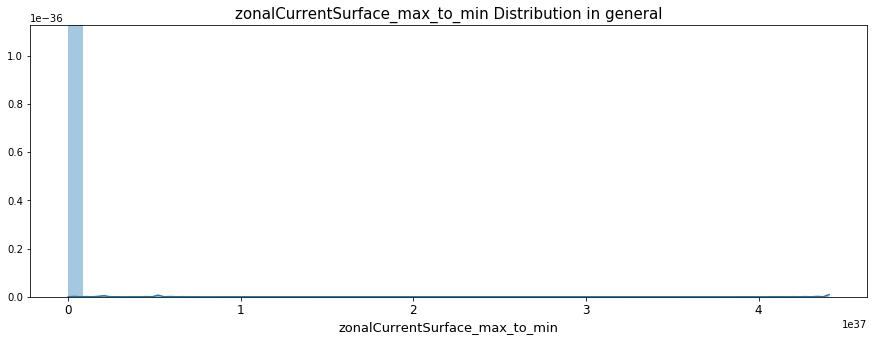

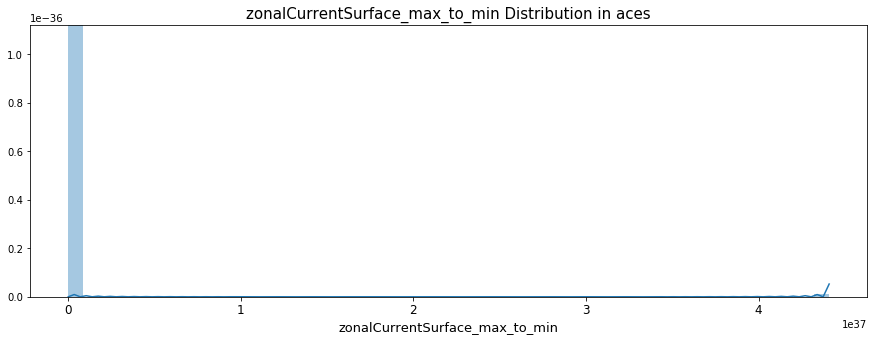

In [23]:
element = 'zonalCurrentSurface_max_to_min'

fig, ax = plt.subplots(figsize=(15, 5))

sns.distplot(train[element])

ax.set_title(element+' Distribution in general', fontsize = 15, loc='center')
ax.set_xlabel(element, fontsize = 13)
plt.tick_params(axis='x', which='major', labelsize=12)
ax.yaxis.tick_left() # where the y axis marks will be

fig, ax = plt.subplots(figsize=(15, 5))

sns.distplot(aces_df[element])

ax.set_title(element+' Distribution in aces', fontsize = 15, loc='center')
ax.set_xlabel(element, fontsize = 13)
plt.tick_params(axis='x', which='major', labelsize=12)
ax.yaxis.tick_left() # where the y axis marks will be

### EDA

Let's have a look first at the correlation between numerical features and the target "Overall Probability", in order to have a first idea of the connections between features. Just by looking at the heatmap below we can see many dark colors, many features have high correlation with the target.



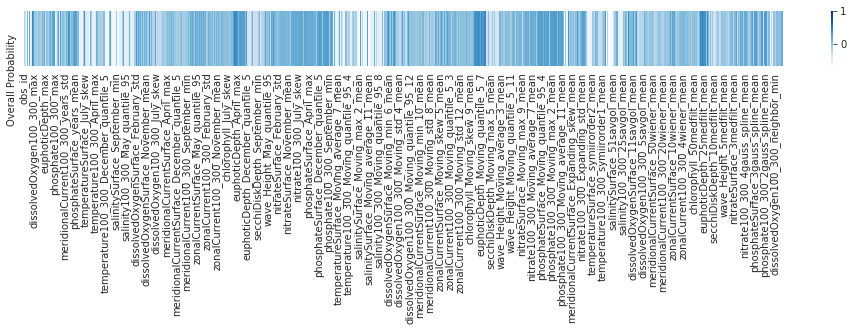

In [25]:
sns.set_style('whitegrid')

num=train_filtered.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['Overall Probability'], ascending=False).head(1), cmap='Blues')
plt.show()

To have a better idea, we sort the features according to their correlation with the *Overall Probability*. We use the absolute value of *Overall Probability* because the negative values of correlation matter just as much

In [26]:
Num=abs(numcorr['Overall Probability']).sort_values(ascending=False).head(20).to_frame()
cm = sns.light_palette("cyan", as_cmap=True)
s = Num.style.background_gradient(cmap=cm)
s

,Overall Probability
Overall Probability,1.000000
salinitySurface_Expanding_average_mean,0.671439
salinitySurface_October_mean,0.669778
salinitySurface_September_mean,0.669596
salinitySurface_Moving_max_2_mean,0.666987
salinitySurface_Moving_quantile_95_2,0.666916
salinitySurface_Moving_quantile_95_3,0.666881
salinitySurface_Moving_max_3_mean,0.666536
salinitySurface_Moving_quantile_95_4,0.664912
salinitySurface_Hilbert_mean,0.664622


Let's Check out the distribution of our Overall Probability we are looking for



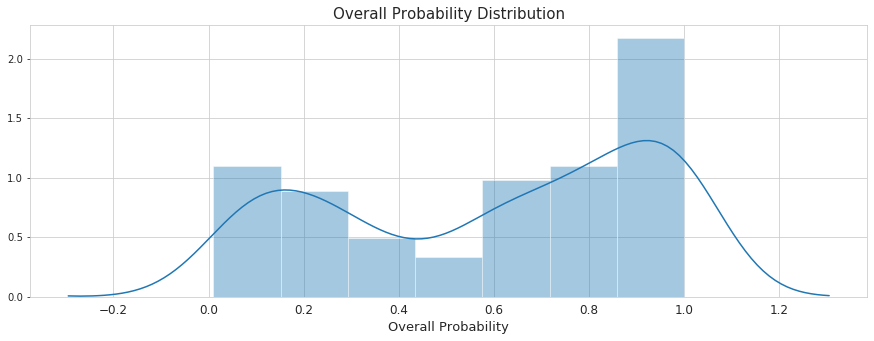

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.distplot(train['Overall Probability'])

ax.set_title('Overall Probability Distribution', fontsize = 15, loc='center')
ax.set_xlabel('Overall Probability', fontsize = 13)
plt.tick_params(axis='x', which='major', labelsize=12)
ax.yaxis.tick_left() # where the y axis marks will be

Join Plot - Draw a scatterplot with marginal histograms

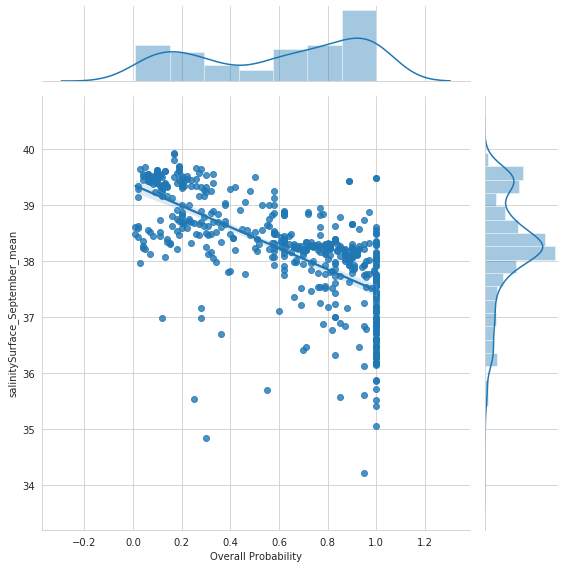

In [28]:
sns.jointplot(train['Overall Probability'], train['salinitySurface_September_mean'], height=8, kind='reg')

As well as a correlation heatmap

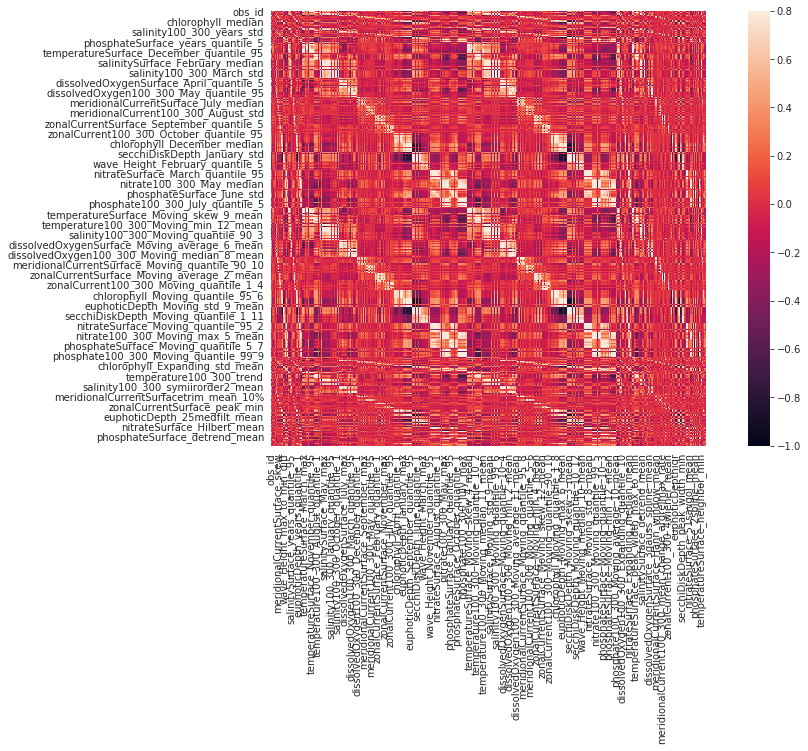

In [29]:
corrmat = train.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(corrmat, vmax=.8, square=True);

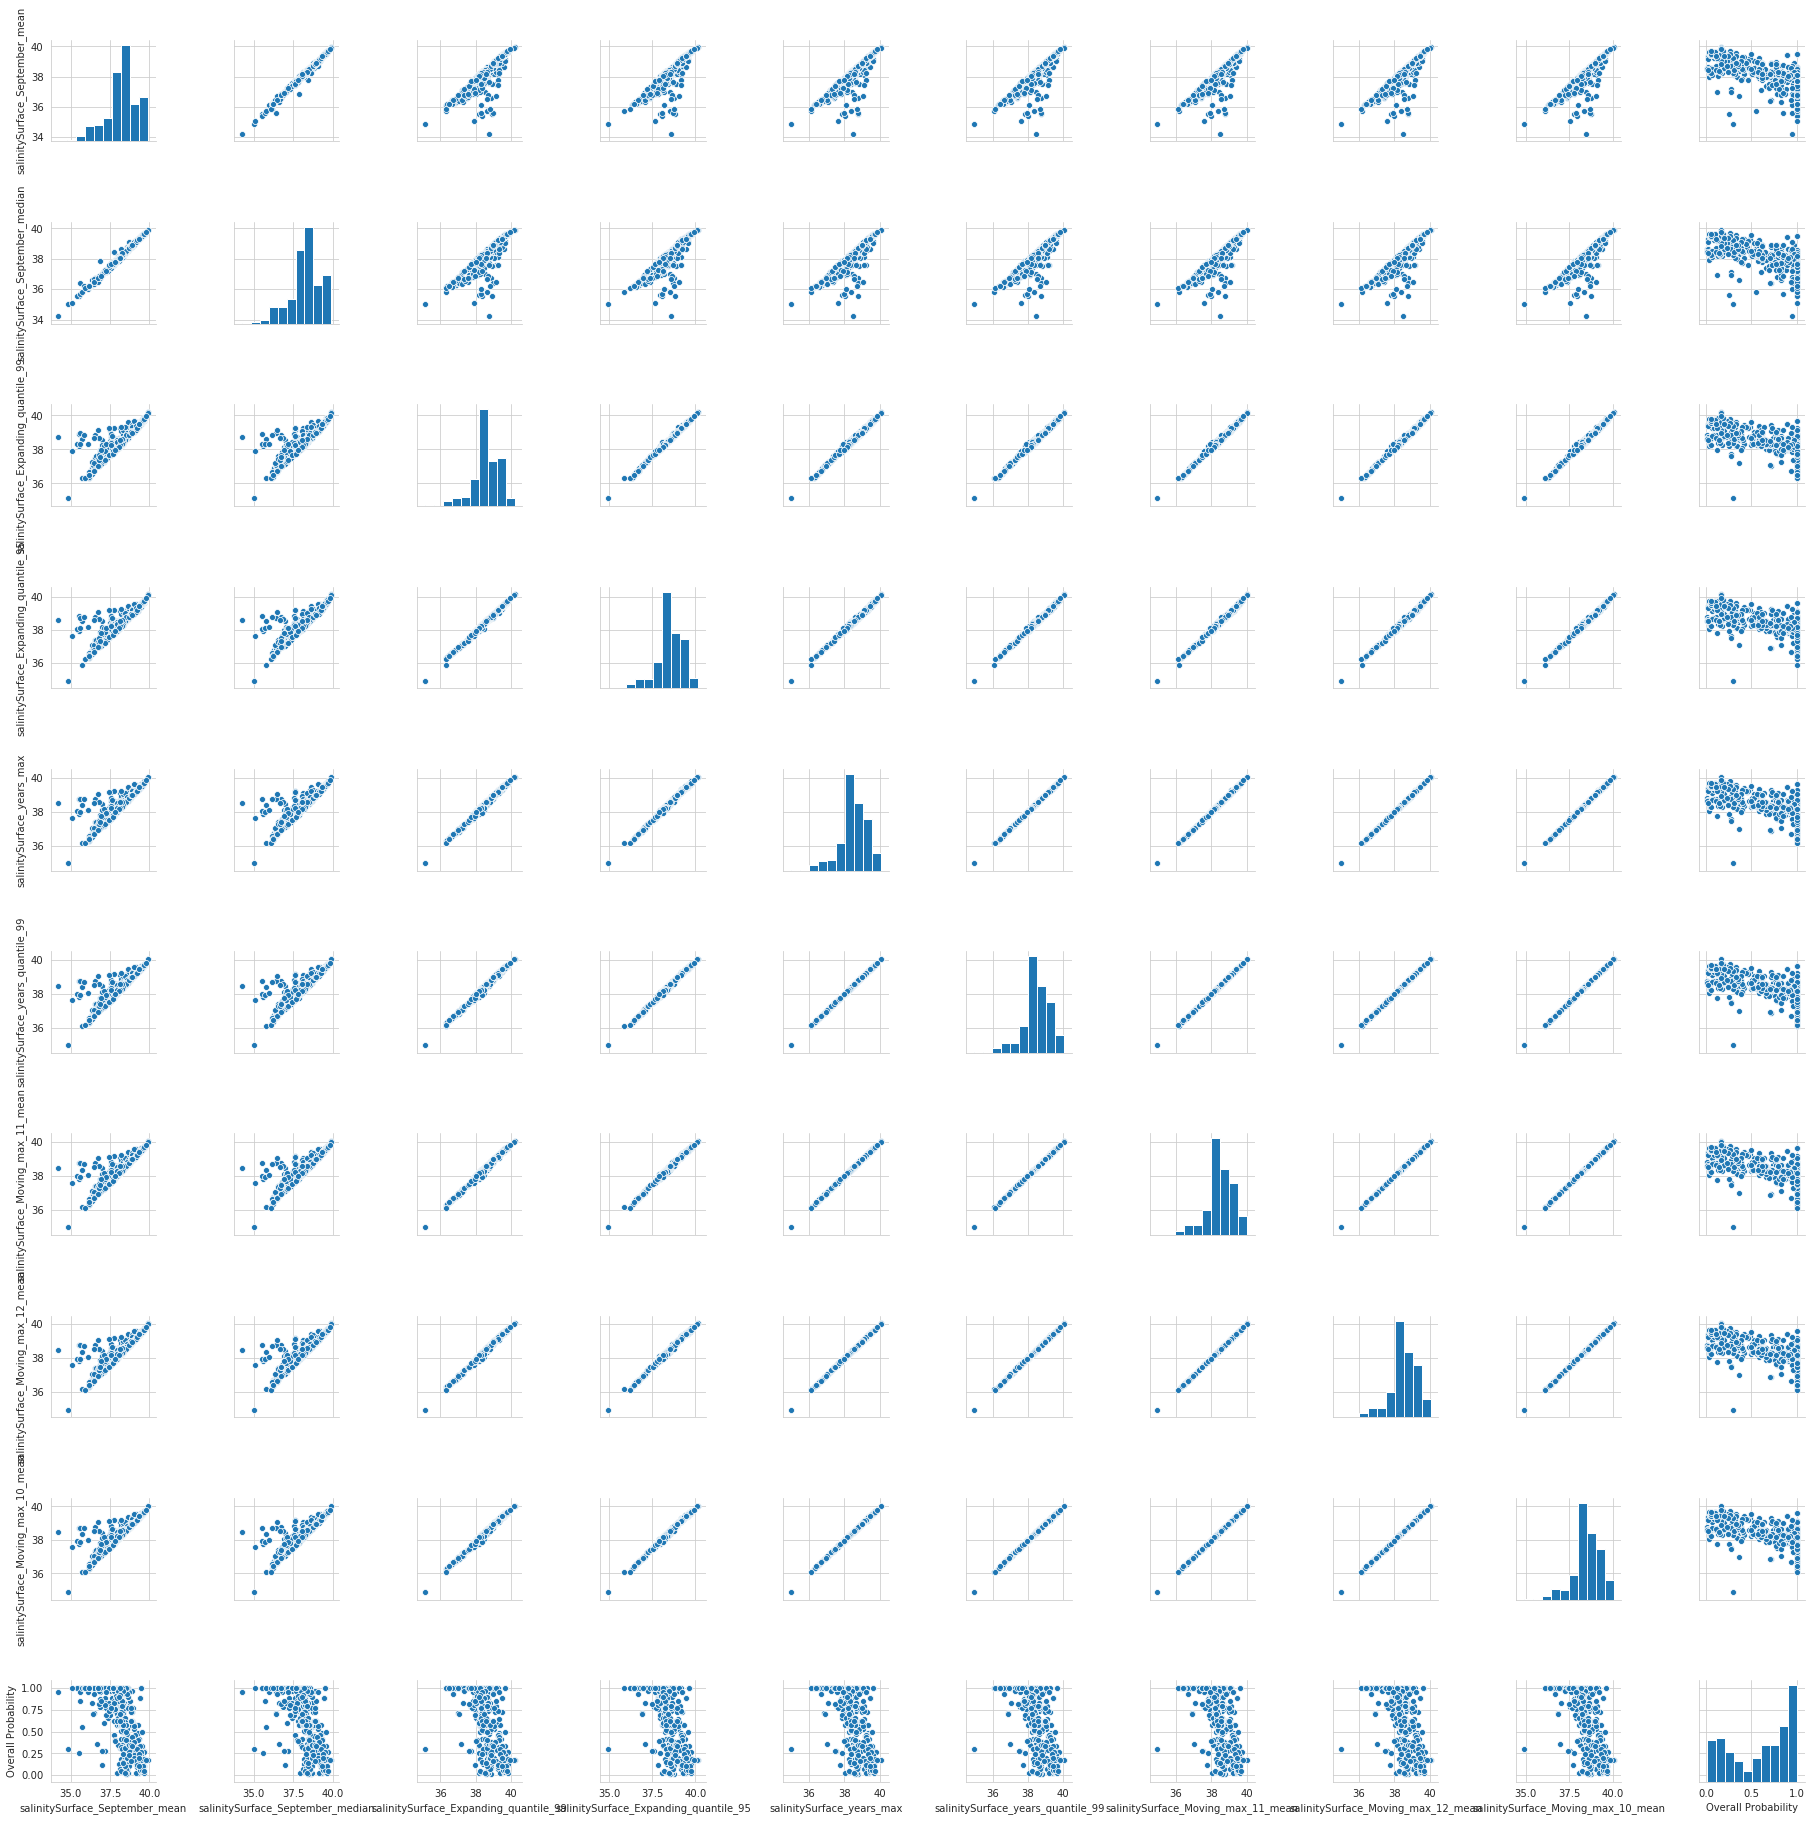

In [30]:
cols = ['salinitySurface_September_mean','salinitySurface_September_median','salinitySurface_Expanding_quantile_99','salinitySurface_Expanding_quantile_95','salinitySurface_years_max'
  ,'salinitySurface_years_quantile_99','salinitySurface_Moving_max_11_mean','salinitySurface_Moving_max_12_mean','salinitySurface_Moving_max_10_mean','Overall Probability']	
sns.pairplot(train[cols], height = 2.5)


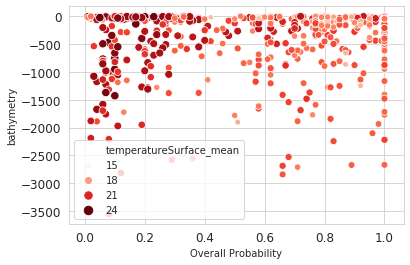

In [31]:
sns.scatterplot(train['Overall Probability'], train['bathymetry'], hue=train['temperatureSurface_mean'], palette='Reds', size=train['temperatureSurface_mean'])
ax.set_title('Overall Probability per bathymetry grouped by Surface Temperature', fontsize = 15, loc='center')
ax.set_xlabel('Overall Probability', fontsize = 13)
ax.set_ylabel('Βathymetry', fontsize = 13)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=12)
ax.yaxis.tick_left() # where the y axis marks will be


### Encode Categorical Features

In [32]:
# Custom substrate labelling

for i in range (0,train['substrateType'].values.size):
    if train['substrateType'].values[i] == "Unknown":
        train['substrateType'].values[i] = 0
    if train['substrateType'].values[i] == "Rock or other hard substrata":
        train['substrateType'].values[i] = 1
    if train['substrateType'].values[i] == 'Coarse and mixed sediment':
        train['substrateType'].values[i] = 2
    if train['substrateType'].values[i] == 'Fine mud':
        train['substrateType'].values[i] = 3
    if train['substrateType'].values[i] == 'Sandy mud':
        train['substrateType'].values[i] = 4
    if train['substrateType'].values[i] == 'Muddy sand':
        train['substrateType'].values[i] = 5
    if train['substrateType'].values[i] == 'Sand':
        train['substrateType'].values[i] = 6
    if train['substrateType'].values[i] == 'Cymodocea nodosa meadows':
        train['substrateType'].values[i] = 7
    if train['substrateType'].values[i] == 'Posidonia oceanica meadows':
        train['substrateType'].values[i] = 8

In [33]:
for df in [train,test]:
    for c in df:
        if (df[c].dtype=='object'):
            lbl = LabelEncoder() 
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(list(df[c].values))

In [ ]:
C_mat = train.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()